In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip as sigmaclip
from scipy.interpolate import interp1d
import astropy.constants as const
from scipy.optimize import curve_fit
import scipy.stats as stats
from tqdm.notebook import tnrange
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading SYSREM residuals

# number of order, frame, wavelength, and SysRem iteration (all refer to data after passing SysRem)
numorder, numframe, numwv, n_sys = 22, 56, 4080, 15

flux_data = np.zeros((numorder,n_sys+1,numframe,numwv))
error_data = flux_data.copy()
wave_data = flux_data.copy()
a_data = np.zeros((numorder,n_sys+1,numframe))
c_data = np.zeros((numorder,n_sys+1,numwv))

for order in range(numorder):
    for sysiter in range(n_sys+1):

    #reading hdf5 file for each SYSREM iteration (default binmedfil=151)
        with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys.hdf5', 'r') as h5f_raw:

            flux_data[order,sysiter] = h5f_raw['flux-order-'+str(order)][()]
            error_data[order,sysiter] = h5f_raw['error-poisson-order-'+str(order)][()]
            wave_data[order,sysiter] = h5f_raw['wv-vac-order-'+str(order)][()]
            airmass = h5f_raw['airmass'][()]
            rvcor = h5f_raw['rv_cor'][()]
            bjd = h5f_raw['bjd'][()]
            mjd = h5f_raw['mjd'][()]
            phase = h5f_raw['phase'][()]
            rel_phase = h5f_raw['rel_phase'][()]
            hour_phase = h5f_raw['hour_phase'][()]
            exptime = h5f_raw['exp_time'][()]
            out_transit_mask = h5f_raw['out_transit_mask'][()]
            transit_weight = h5f_raw['transit_weight'][()]
            carm_order = h5f_raw['carm_order'][()]
            contact_index = h5f_raw['contact_index'][()]

            if sysiter != 0:
                a_data[order,sysiter-1] = h5f_raw['a-coeff-order-'+str(order)][()]
                c_data[order,sysiter-1] = h5f_raw['c-coeff-order-'+str(order)][()]

In [3]:
# calculate instrument FWHM
c = const.c.value/1000. #km/s
fwhm = c / 80400
print(str(fwhm)+' km/s')

diff = []
for order in range(wave_data.shape[1]):
    for wv in range(wave_data.shape[3]):
        if wv != wave_data.shape[3]-1:
            diff.append((wave_data[order][0][0][wv+1]-wave_data[order][0][0][wv])/wave_data[order][0][0][wv]*const.c.value/1000)
sampling = round(np.mean(diff),2)

print(str(sampling)+' km/s')

3.7287619154228855 km/s
1.35 km/s


In [4]:
# reading model
flux_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_flux_normalized.pkl')
wave_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_wave_normalized.pkl')

In [5]:
def kpvsys_calc(Kp, Vsys, RV, data, vsys_planet, orb_phase, RV_bary, mask):

    """
    Interpolate CCF values to a range of Kp and Vsys

    Args:
        kp          : K_p sample in km/s
        vsys        : V_sys sample in km/s
        drvs        : RV sample in km/s
        data        : Cross-correlation values to be interpolated (frame x RV)
        vsys_planet : The expected V_sys of the planet
        orb_phase   : Orbital phase of the planet
        brv         : Correction for barycentric velocity
        mask        : A mask for out-transit frames

    Return:
        summed      : Interpolated CCF values
    """

    data = data[mask]
    orb_phase = orb_phase[mask]
    RV_bary = RV_bary[mask]

    kpvsys_frame = np.zeros([Kp.size] + [data.shape[0]] + [Vsys.size])
    for kp_idx,kp in enumerate(Kp):

        # aligning the in-trail CCF to the planetary rest-frame (Vsys ~ 0 km/s)
        RV_predict = kp * np.sin(2. * np.pi * orb_phase) + RV_bary + vsys_planet

        for phase_idx in range(orb_phase.size):
            kpvsys_frame[kp_idx,phase_idx] = interp1d(RV,data[phase_idx],kind='linear')(RV_predict[phase_idx] + Vsys)

    kpvsys_map = kpvsys_frame.sum(axis=1)
    return kpvsys_map

def fitting_histogram(distribution,plot=True):

    # making the histogram
    num_bins = int(1 + 3.322*np.log10(len(distribution))) # following Sturge's rule
    hist_ = plt.hist(distribution,histtype="step",align='mid',bins=num_bins)

    # assigning the value of each bin and the x-axis of the bin itself ~ (right_edge+left_edge)/2
    x_hist_edges,y_hist = hist_[1],hist_[0]
    x_hist = (x_hist_edges[:-1] + x_hist_edges[1:])/2

    # calculating the Gaussian PDF values given Gaussian parameters and random variable X
    def gaus(X, C, X_mean, sigma):
        return C * np.exp(-(X - X_mean)**2 / (2 * sigma**2))
    
    # calculate the mean and standard deviation
    # the standard deviation is the square root of the variance of the distribution, which is defined as the average of the squared differences of the data from the mean.
    mean = sum(x_hist * y_hist) / sum(y_hist)
    sigma = sum(y_hist * (x_hist-mean)**2) / sum(y_hist)

    # Gaussian least-square fitting process
    # the constant C is just a normalization factor, so we can use the maximum value of the distribution
    param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

    # plotting the histogram
    if plot:
        plt.hist(distribution,histtype="step",align='mid',bins=num_bins)
        plt.plot(x_hist,y_hist,label='data')
        plt.plot(x_hist,gaus(x_hist,*param_optimised),label='fit')
        plt.legend()
        plt.show()
        plt.clf()

    # print fit Gaussian parameters
    print("Fit parameters: ")
    print("=====================================================")
    print("C = ", param_optimised[0], "+-", np.sqrt(param_covariance_matrix[0, 0]))
    print("X_mean =", param_optimised[1], "+-", np.sqrt(param_covariance_matrix[1, 1]))
    print("sigma = ", param_optimised[2], "+-", np.sqrt(param_covariance_matrix[2, 2]))
    print("\n")

    return np.abs(param_optimised[2])

In [6]:
# function for cross-correlating model with data, creating Kp-Vsys map, and calculating log-likelihood  mapping
def detect_molecules(wavedat, fluxdat, errordat, wave_modelmol, flux_modelmol,
                     sysrem_iteration, carm_order,
                     RV_sample, Vrest_sample,
                     Kp_planet, Vsys_planet,
                     transit_weight, rvcor, phase):

    CC_total_norm_final = []
    CC_shifted_final = []
    CC_combine_final = []
    for sys_iter in range(sysrem_iteration):

        if sys_iter != 0:

            print('################ SYSREM '+str(sys_iter)+' #####################')
            
            K1_all,K2_all,CC_all,N_data = [],[],[],[]
            for idx,order in enumerate(carm_order):

                flux_obs = fluxdat[idx][sys_iter].copy()
                wave_obs = wavedat[idx][sys_iter].copy()
                error_obs = errordat[idx][sys_iter].copy()

                # masking model to the corresponding order wavelength
                masktemp = (wave_modelmol > wave_obs[0][0] - 20) * (wave_modelmol < wave_obs[0][-1] + 20)
                wave_mod,flux_mod = wave_modelmol[masktemp],flux_modelmol[masktemp]

                # Doppler-shift the model (RV_sample x wavelength)
                wave_mod_shifted = wave_obs[0][np.newaxis,:] / (1 + RV_sample*1000/const.c.value)[:,np.newaxis]
                flux_mod_shifted = np.interp(wave_mod_shifted,wave_mod,flux_mod)

                # putting the Doppler-shifted model into common continuum level
                flux_mod_shifted -= np.nanmedian(flux_mod_shifted,axis=1)[:,np.newaxis]
                maskpix = error_obs[0]!=np.inf
                for frame in range(error_obs.shape[0]):
                    flux_obs[frame][maskpix==True] = flux_obs[frame][maskpix] - np.nanmedian(flux_obs[frame][maskpix])

                # calculating the summation terms in the chi^2 equation
                K1 = np.nansum(flux_obs**2/error_obs**2,axis=1)
                K2 = np.dot(1./error_obs**2,(flux_mod_shifted**2).T)
                CC = np.dot(flux_obs/error_obs**2,flux_mod_shifted.T)

                K1_all.append(K1)
                K2_all.append(K2)
                CC_all.append(CC)
                N_data.append(len(wave_obs[0]))

            # summing over orders
            CC_total = np.sum(CC_all,axis=0)

            # normalizing
            CC_total_norm = CC_total - np.nanmedian(CC_total,axis=1)[:,np.newaxis]

            # expected RV path
            RV_planet = Kp_planet * np.sin(2. * np.pi * phase) + (-rvcor) + Vsys_planet

            # shifting to planetary rest frame
            CC_shifted = np.zeros([phase.size] + [Vrest_sample.size])
            for frame in range (phase.size):
                CC_shifted[frame] = interp1d(RV_sample,CC_total_norm[frame])(RV_planet[frame] + Vrest_sample)
            
            # combine weighted values over time
            CC_combine = np.sum(CC_shifted * transit_weight[:,np.newaxis], axis=0)

            CC_total_norm_final.append(CC_total_norm)
            CC_shifted_final.append(CC_shifted)
            CC_combine_final.append(CC_combine)

    return CC_total_norm_final

# Welch-t Test

In [7]:
sampling = 1.30
RV_sample = np.arange(-350,350,sampling)    # in km/s
Kp_sample = np.arange(0,300,sampling)       # in km/s
Vsys_sample = np.arange(-120,120,sampling)  # in km/s
A_sample = np.arange(-5.,5.,0.001)

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

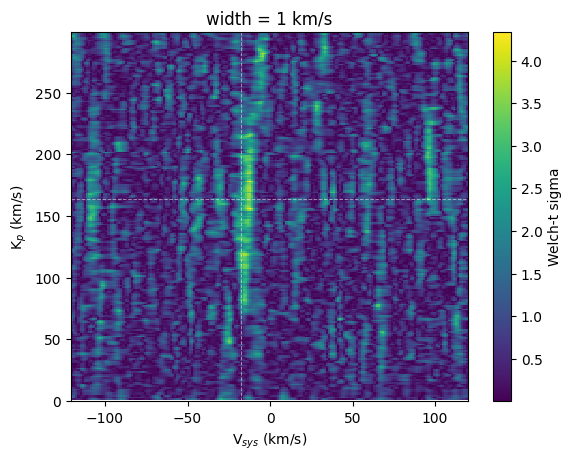

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

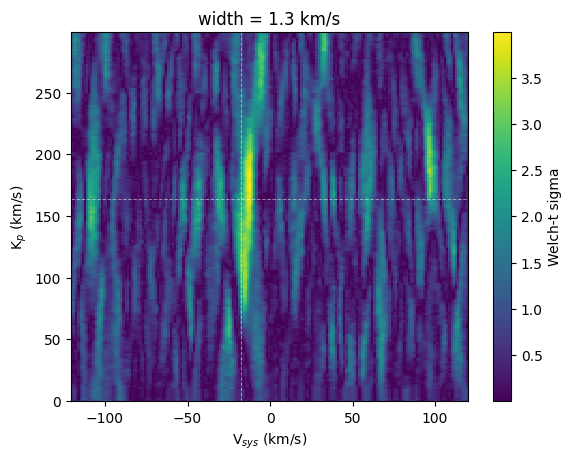

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

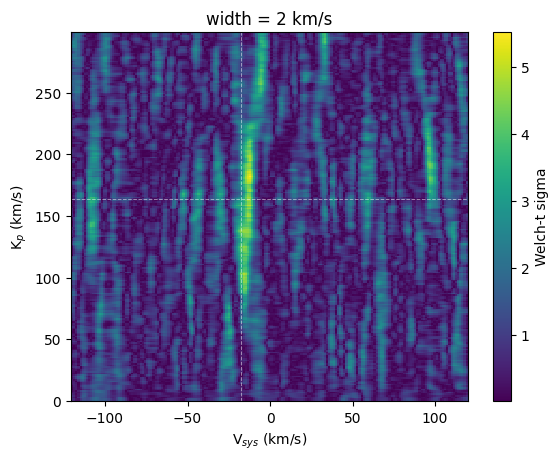

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

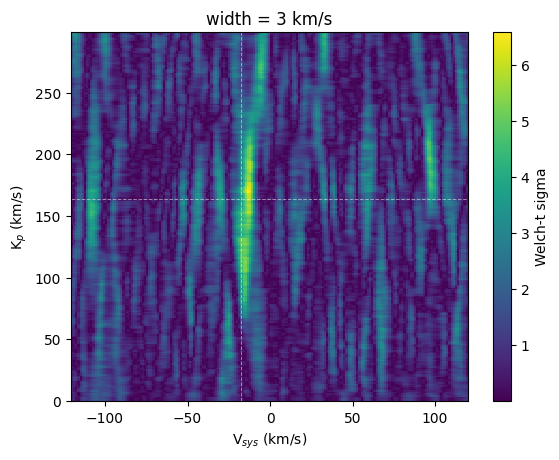

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

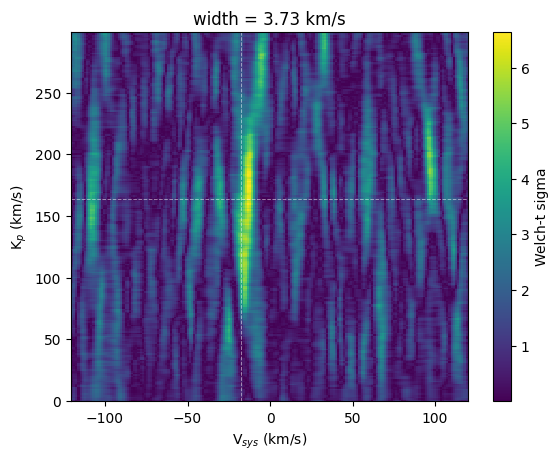

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

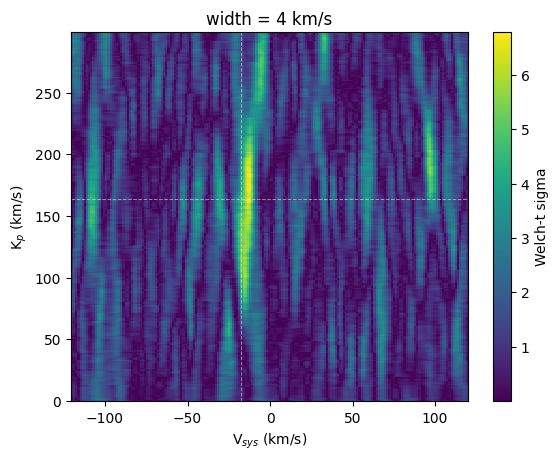

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

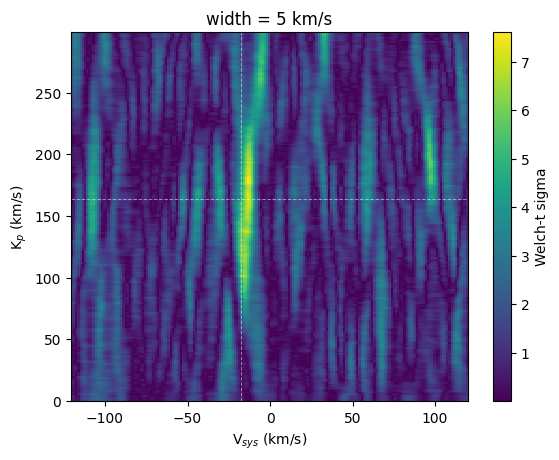

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

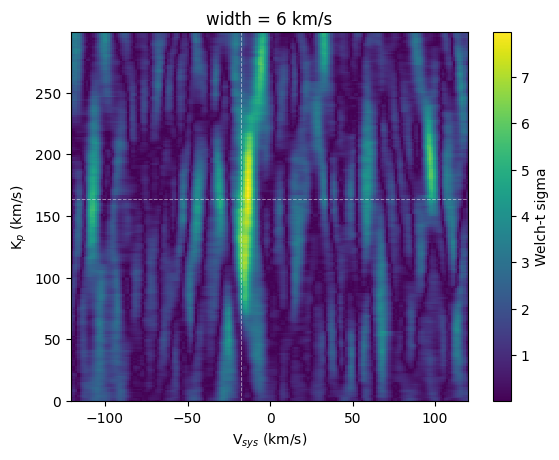

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

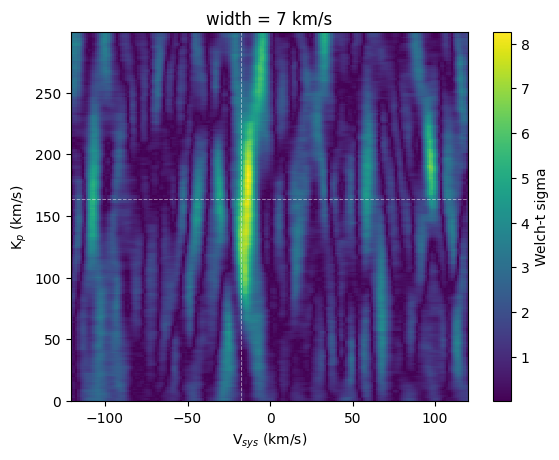

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

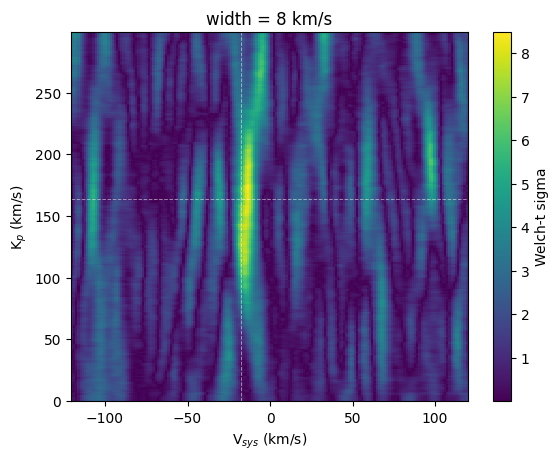

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

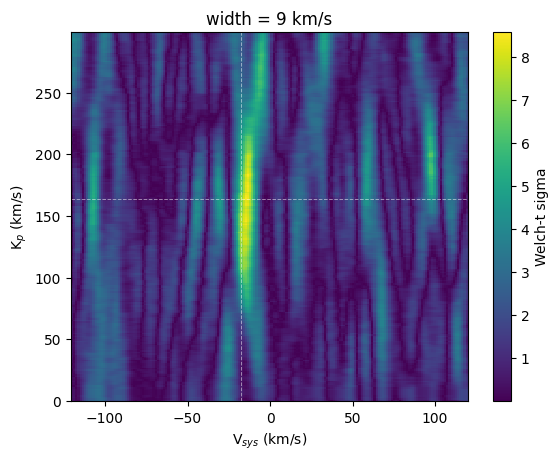

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

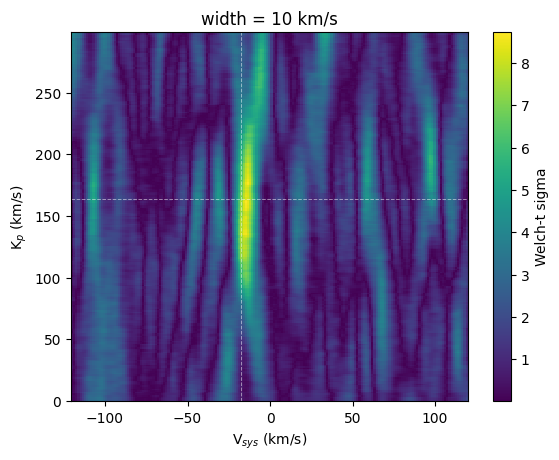

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

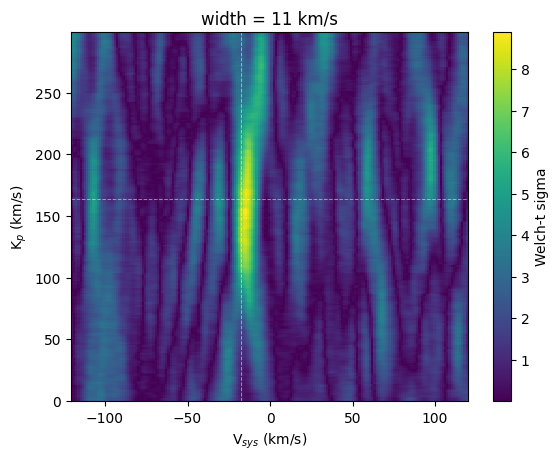

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

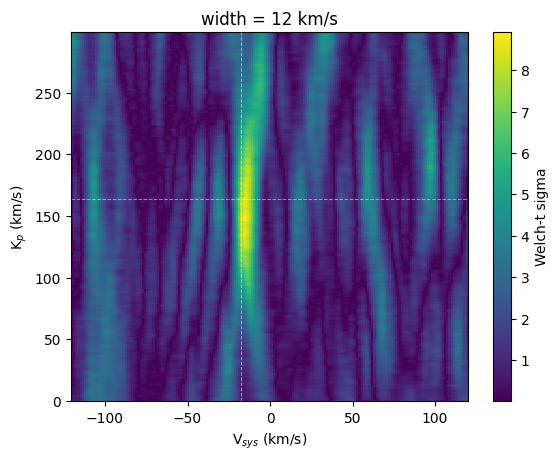

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

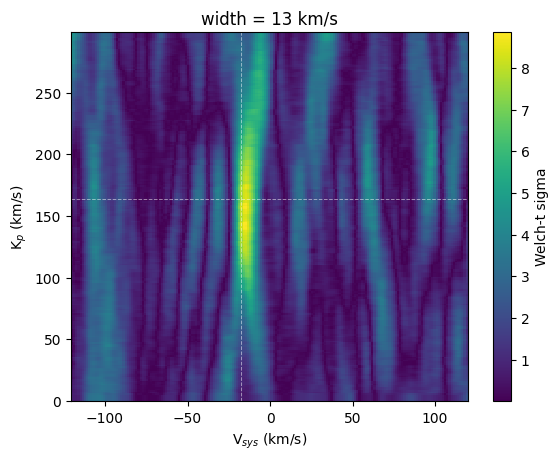

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

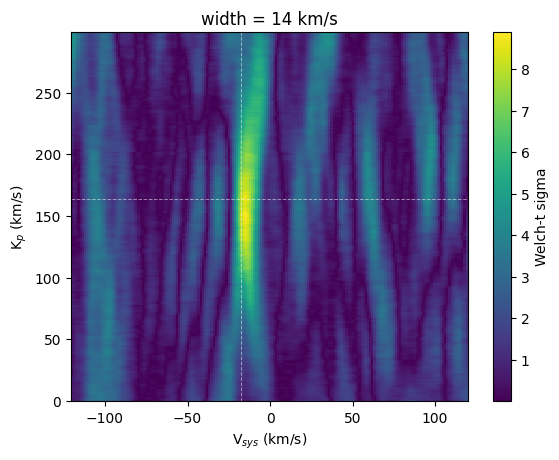

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

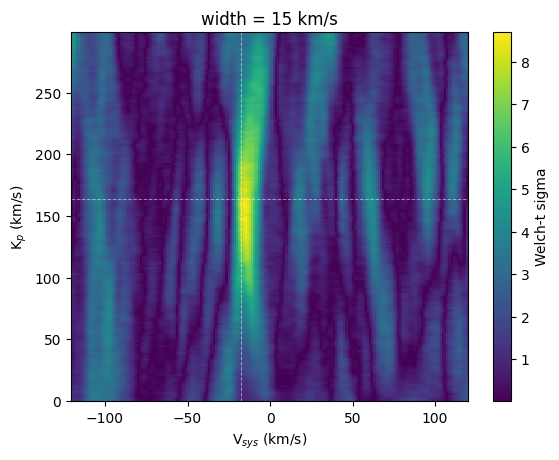

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

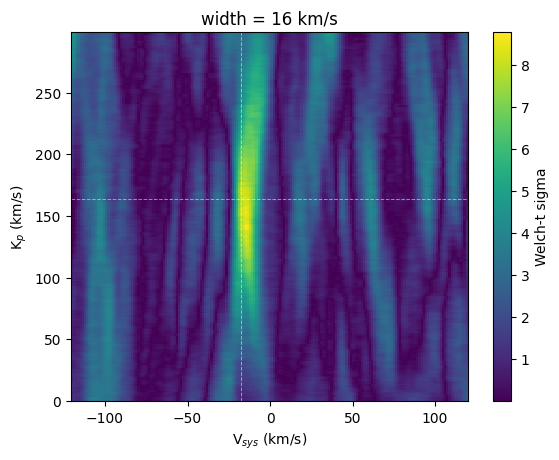

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

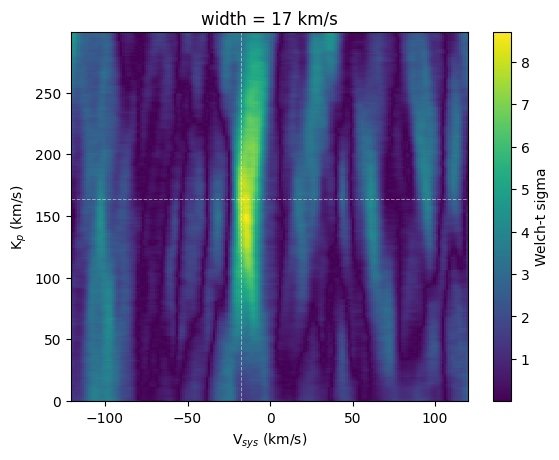

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

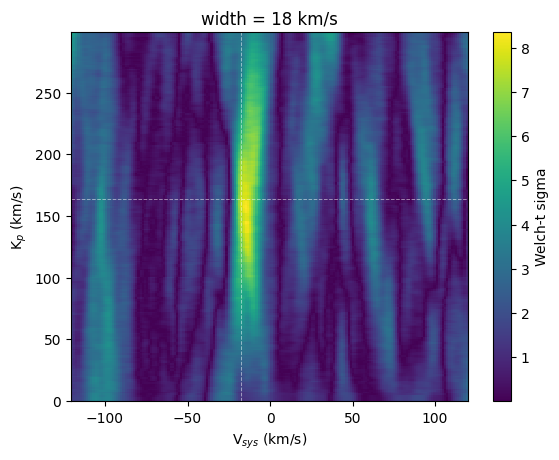

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

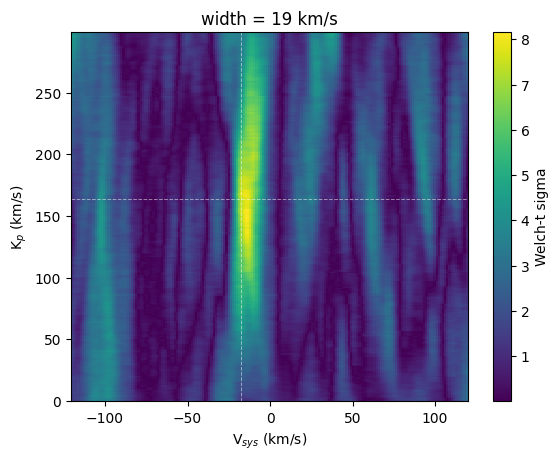

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

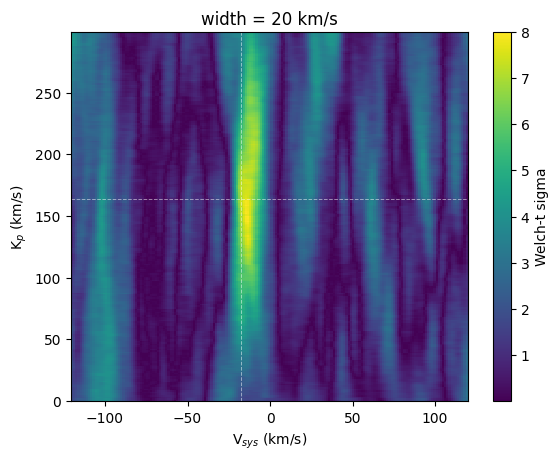

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

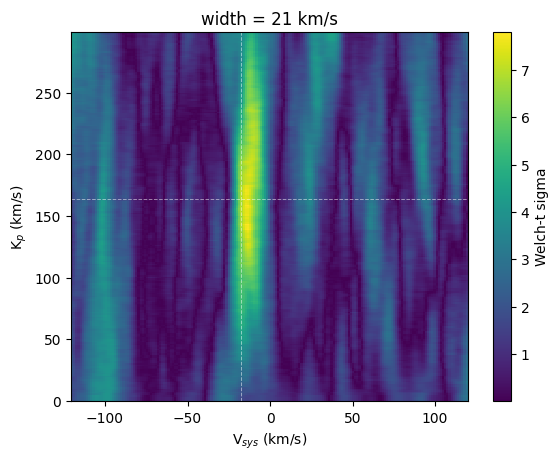

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

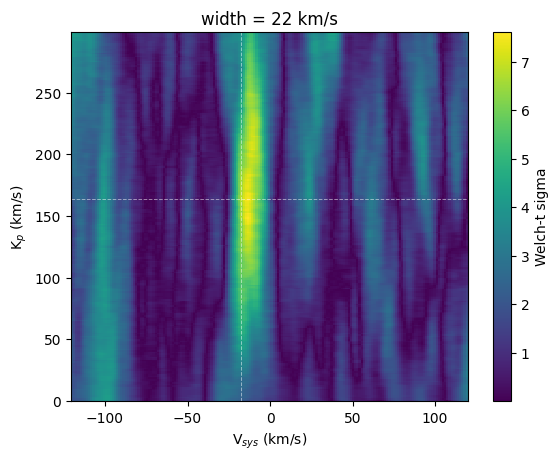

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

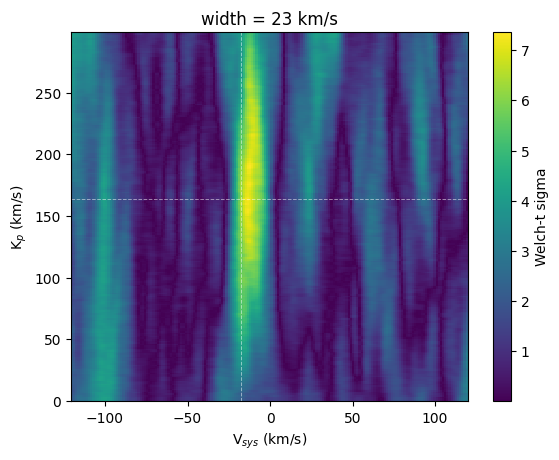

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

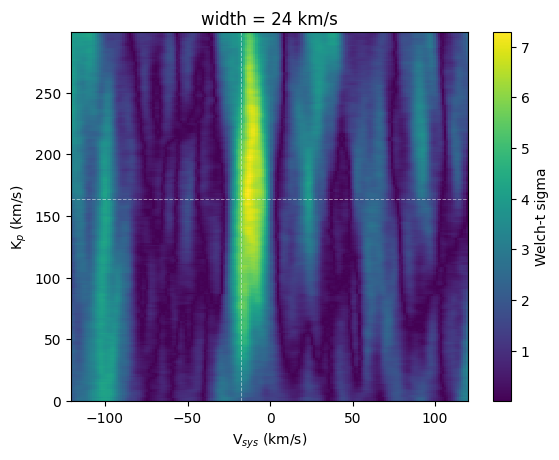

################ SYSREM 1 #####################


  0%|          | 0/231 [00:00<?, ?it/s]

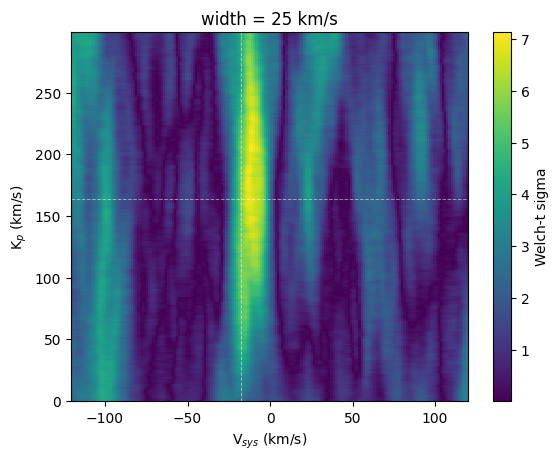

In [8]:
width = [1,1.3,2,3,3.73,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] # explore a range of width values in km/s
sampl = 1.30

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

kp_planet = 164.27
vsys_planet = -17.91

vsys_exp = find_nearest(Vsys_sample,vsys_planet)
kp_exp = find_nearest(Kp_sample,kp_planet)

sig_crosscor = []
sig_max = []
vsys_max,kp_max = [],[]
welch_sig = np.zeros((len(width),len(Kp_sample),len(Vsys_sample)))
i = 0

for wd in width:

    RV_sample = np.arange(-350,350,sampl)
    Kp_sample = np.arange(0,300,sampl)
    Vsys_sample = np.arange(-120,120,sampl)
    sys_num = 1

    wvdat,fluxdat,errdat = wave_data,flux_data,error_data
    cc = detect_molecules(wvdat,fluxdat,errdat,wave_modelmol,flux_modelmol,sys_num+1,carm_order,
                RV_sample,Vsys_sample,
                kp_planet,vsys_planet,transit_weight,rvcor,phase)

    maskoutrans = out_transit_mask
    welch_map = np.zeros([Kp_sample.size]+[Vsys_sample.size])

    for idx_kp in tnrange(len(Kp_sample)):
        rvp = (Kp_sample[idx_kp] * np.sin(2. * np.pi * phase) - rvcor)[maskoutrans>0]
        r = rvp + Vsys_sample[:,np.newaxis]

        r_max_it = r + wd/2
        r_min_it = r - wd/2
        r_max_ot = r_max_it + 5
        r_min_ot = r_min_it - 5

        maskit = ((RV_sample[np.newaxis,:] < r_max_it[:,:,np.newaxis])*(RV_sample[np.newaxis,:] > r_min_it[:,:,np.newaxis]))
        maskot = ((RV_sample[np.newaxis,:] < r_max_ot[:,:,np.newaxis])*(RV_sample[np.newaxis,:] > r_min_ot[:,:,np.newaxis]))
        top = np.repeat(cc[0][maskoutrans>0][np.newaxis,...], Vsys_sample.size, axis=0)
        for idx_vsys in range(len(Vsys_sample)):
            itt = top[idx_vsys][maskit[idx_vsys]]
            ott = top[idx_vsys][~maskot[idx_vsys]]
            welch_map[idx_kp,idx_vsys] = norm.isf(stats.ttest_ind(np.array(itt), np.array(ott), equal_var = False)[1]/2)

    plt.figure()
    mapcolorbar = plt.pcolormesh(Vsys_sample,Kp_sample,welch_map)
    plt.colorbar(mapcolorbar,label="Welch-t sigma")
    plt.title('width = '+str(wd)+' km/s')
    plt.xlabel(r'V$_{sys}$ (km/s)')
    plt.ylabel(r'K$_{p}$ (km/s)')
    plt.axvline(x=Vsys_sample[vsys_exp],color="white",ls="--",alpha= 0.5,lw=0.7)
    plt.axhline(y=Kp_sample[kp_exp],color="white",ls="--",alpha= 0.5,lw=0.7)
    plt.show()

    vsys_real = find_nearest(Vsys_sample,-17.91+4.8)    # location based on the cross-correlation result
    kp_real = find_nearest(Kp_sample,162.50)            # location based on the cross-correlation result
    sig_crosscor.append(welch_map[kp_real,vsys_real])
    sig_max.append(welch_map.max())
    # vsys_max.append(Vsys_sample[np.where(welch_map == welch_map.max())[1][0]])
    # kp_max.append(Kp_sample[np.where(welch_map == welch_map.max())[0][0]])
    welch_sig[i] = welch_map

    i+=1

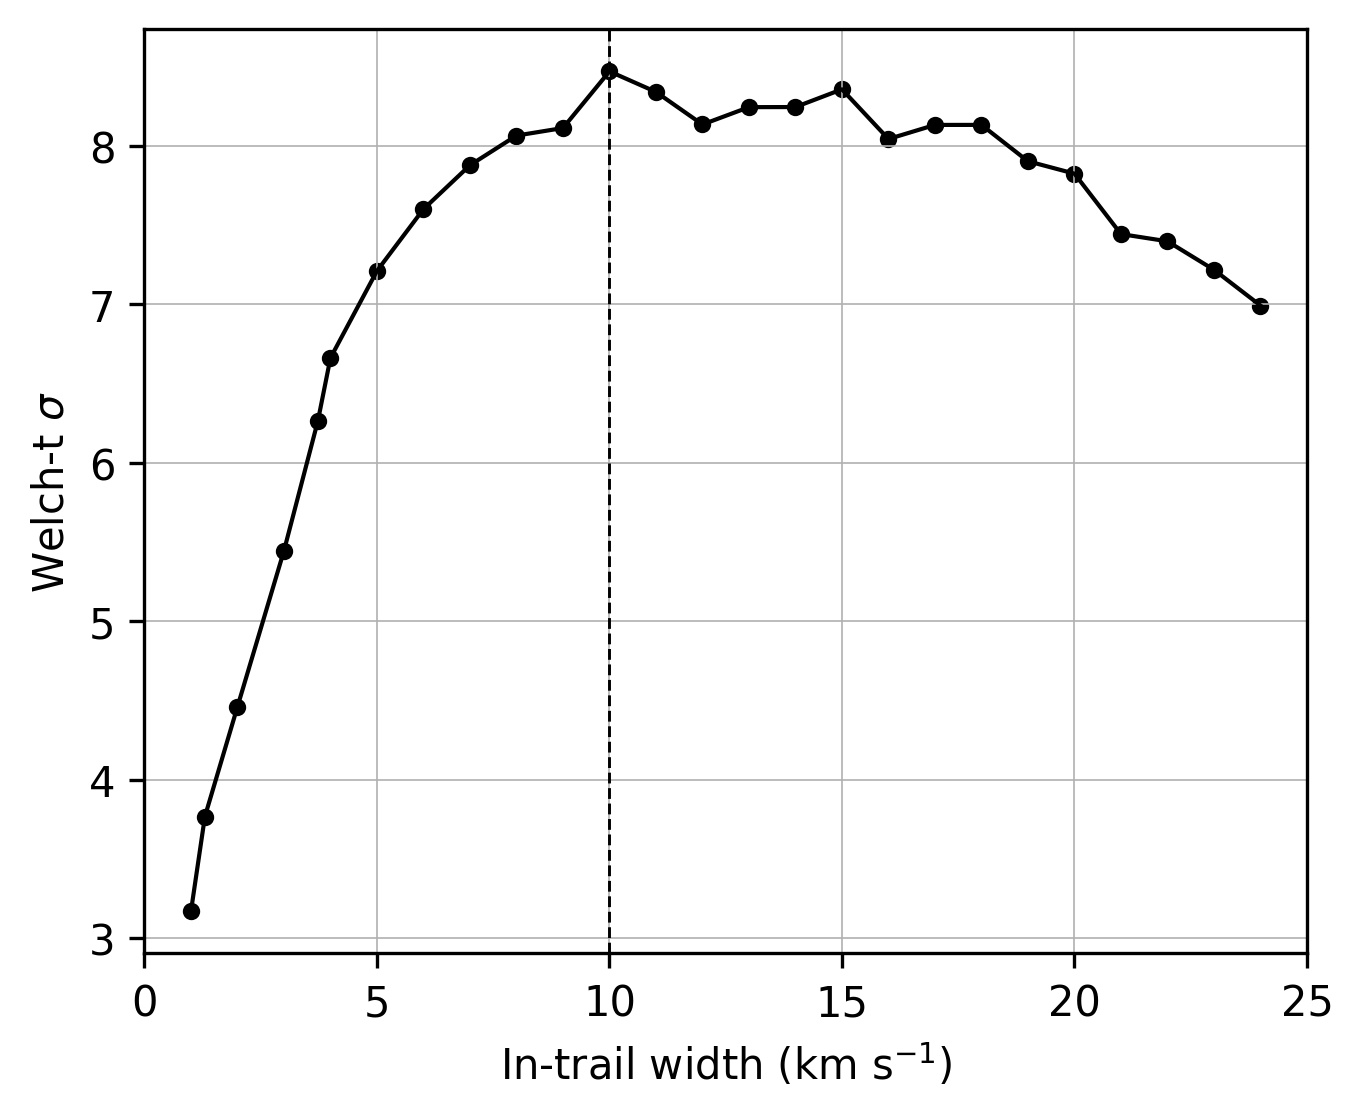

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(5,4),dpi=300)
plt.plot(width[:-1],sig_crosscor[:-1],lw=1,c='black')
plt.scatter(width[:-1],sig_crosscor[:-1],s=10,c='black')
plt.axvline(x=width[np.where(sig_crosscor==np.max(sig_crosscor[1:]))[0][0]],ls='--',lw=0.7,c='black')
plt.xlabel('In-trail width (km s$^{-1}$)')
plt.ylabel(r'Welch-t $\sigma$')
plt.xlim(0,25)
plt.grid(lw=0.4)
plt.savefig("figures/intrail_width.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show()
plt.clf()

# Plots for Paper

In [7]:
import batman
import math

In [8]:
sampling = 1.30
RV_sample = np.arange(-350,350,sampling)    # in km/s
Kp_sample = np.arange(0,300,sampling)       # in km/s
Vsys_sample = np.arange(-120,120,sampling)  # in km/s
Kp_planet = 164.27                          # in km/s (calculated from formula given in Exoplanets (Seager, 2010))
Vsys_planet = -17.91                        # in km/s (calculated from stellar RV analysis)
A_sample = np.arange(-5.,5.,0.01)
sys_num = 1

wvdat,fluxdat,errdat = wave_data,flux_data,error_data

cc = detect_molecules(wvdat,fluxdat,errdat,wave_modelmol,flux_modelmol,sys_num+1,carm_order,
                RV_sample,Vsys_sample,Kp_planet,Vsys_planet,transit_weight,rvcor,phase)

class Light_Curve():

    def __init__(self,BJD,**kwargs):
        self.__dict__.update(**kwargs)
        self.bjd = BJD

    def calc_LC(self,elliptic=True):

        R_jup = const.R_jup.value # meter
        R_sun = const.R_sun.value # meter
        
        # defining batman parameters
        params = batman.TransitParams()                                         # object to store transit parameters
        params.t0 = self.__dict__['T0']                                         # time of inferior conjunction (BJD)
        params.per = self.__dict__['P']                                         # orbital period (days)
        params.rp = (self.__dict__['R_p']*R_jup)/(self.__dict__['R_s']*R_sun)     # planet radius (units of stellar radii)
        params.a = self.__dict__['ap']                                          # semi-major axis (units of stellar radii)
        params.inc = self.__dict__['inc']                                       # orbital inclination (degrees)
        params.ecc = self.__dict__['e']                                         # eccentricity
        params.w = self.__dict__['w']                                           # longitude of periastron (degrees)
        params.limb_dark = self.__dict__['limb_dark_model']                     # limb darkening model
        params.u = self.__dict__['limb_dark_coeff']                             # limb darkening coefficients

        time = np.array(self.bjd)
        model = batman.TransitModel(params,time)
        flux_batman = model.light_curve(params)

        # calculating phase and relative phase from mid-transit
        phase = (time - self.__dict__['T0'])/self.__dict__['P'] % 1
        relative_phase = []
        for ph in range(phase.size):
            relative_phase.append(phase[ph] - 1) if phase[ph] > 0.5 else relative_phase.append(phase[ph])
        hour_phase = np.array(relative_phase) * self.__dict__['P'] * 24 # in hour (assuming 24 hours a day)

        # mask for out-transit frames (outside ingress and egress)
        mask_out_transit = 1 - flux_batman
        for fl in range(flux_batman.size):
            if mask_out_transit[fl] != 0: mask_out_transit[fl] = 1 

        # transit weight for cross-correlation calculation
        transit_weight = (1. - flux_batman)/np.max(1. - flux_batman)
        
        ########## estimating first to fourth contact (calculated following Exoplanets, 2010) ##########

        ap, inc, e, w = self.__dict__['ap'],self.__dict__['inc'],self.__dict__['e'],self.__dict__['w']
        T0, P, R_p, R_s = self.__dict__['T0'],self.__dict__['P'],self.__dict__['R_p']*R_jup,self.__dict__['R_s']*R_sun

        b = ap * np.cos(math.radians(inc)) * (1 - e**2)\
            / (1 + e*np.sin(math.radians(w))) # impact parameter
        
        if elliptic:
            total_duration = P / np.pi * np.arcsin(1/ap * (np.sqrt((1+R_p/R_s)**2 - b**2))/(np.sin(math.radians(inc)))) # from first to fourth contact
            full_duration = P / np.pi * np.arcsin(1/ap * (np.sqrt((1-R_p/R_s)**2 - b**2))/(np.sin(math.radians(inc)))) # from second to third contact
            ingress_to_egress = (total_duration - full_duration)/2
        else:
            ingress_to_egress = P / (ap*np.pi) / np.sqrt(1-b**2) * R_p / R_s

        intrans_frame = []
        for idx in range(len(flux_batman)-1):
            if np.abs(flux_batman[idx]-flux_batman[idx+1]) > 0.:
                intrans_frame.append(idx)
        intrans_frame[-1] += 1 # to anticipate last index

        contact_time = [time[intrans_frame[0]], time[intrans_frame[0]]+ingress_to_egress,time[intrans_frame[-1]]-ingress_to_egress,time[intrans_frame[-1]]]
        contact_index = np.argmin(np.abs(time - np.asarray(contact_time)[:,np.newaxis]),axis=1)

        ###############################################################################################

        return phase,relative_phase,hour_phase,mask_out_transit,transit_weight,contact_index
    
bjd_temp = np.array([58586.425974 , 58586.4288213, 58586.4315297, 58586.4360958,
       58586.4396028, 58586.4426295, 58586.4457314, 58586.4509689,
       58586.4538567, 58586.4569644, 58586.4613974, 58586.4650838,
       58586.4683652, 58586.4724799, 58586.4752867, 58586.4787069,
       58586.483707 , 58586.4872488, 58586.4894132, 58586.4949226,
       58586.4982271, 58586.5009124, 58586.5059762, 58586.5088061,
       58586.5120354, 58586.5151662, 58586.5181466, 58586.5213354,
       58586.5259536, 58586.5285925, 58586.5326146, 58586.5358381,
       58586.5387259, 58586.5420709, 58586.5472042, 58586.5500167,
       58586.5525978, 58586.5565505, 58586.5592647, 58586.5622914,
       58586.566192 , 58586.5697627, 58586.57375  , 58586.5763774,
       58586.5800407, 58586.5832179, 58586.5886636, 58586.5903072,
       58586.5946708, 58586.5970551, 58586.6007994, 58586.6039187,
       58586.6075068, 58586.6098564, 58586.6153253, 58586.6182189,
       58586.621234 , 58586.6239424, 58586.6276462, 58586.6307018,
       58586.6336649, 58586.6369983, 58586.6413619, 58586.6438388,
       58586.6475252, 58586.6511017, 58586.6541689, 58586.6563044,
       58586.6597304, 58586.6633648, 58586.6685096, 58586.6720861])

rvcor = np.array([8.600763, 8.598914, 8.597071, 8.593778, 8.591093, 8.588666,
       8.586075, 8.581464, 8.578796, 8.575825, 8.571411, 8.567585,
       8.564062, 8.559489, 8.556272, 8.552246, 8.546154, 8.541694,
       8.538909, 8.531625, 8.527122, 8.523391, 8.516182, 8.512057,
       8.507267, 8.502539, 8.497965, 8.492993, 8.48565 , 8.481381,
       8.474776, 8.469399, 8.464519, 8.458795, 8.449867, 8.444904,
       8.440306, 8.433188, 8.428248, 8.42269 , 8.415456, 8.408764,
       8.401217, 8.396204, 8.389163, 8.38301 , 8.37237 , 8.369138,
       8.36051 , 8.355769, 8.34829 , 8.342029, 8.334796, 8.330044,
       8.318937, 8.313039, 8.306879, 8.301336, 8.293742, 8.287468,
       8.281378, 8.274523, 8.265547, 8.260452, 8.252874, 8.245529,
       8.239238, 8.234865, 8.22786 , 8.220447, 8.209994, 8.20276 ])

# param for batman package
param = {} # case-sensitive
param['T0'] = 54597.70713                   # transit midpoint, BJD-2400000 (Bonomo+ 2017)
param['P'] = 2.8758916                      # period, days (Bonomo+ 2017)
param['R_p'] = 0.811                        # planet radius, Jupiter radii (Bonomo+ 2017)
param['R_s'] = 1.41                         # star radius, Sun radii (Stassun+ 2017)
semi_major = 0.04364                        # semi-major axis, AU (Bonomo+ 2017)
param['ap'] = semi_major*const.au.value\
    /(param['R_s']*const.R_sun.value)       # stellar radii
param['inc'] = 84.50                        # inclination, degrees (Bonomo+ 2017)
param['e'] = 0                              # eccentricity
param['w'] = 90                             # longitude of periastron, degrees

# calculated from https://exoctk.stsci.edu/limb_darkening using NIRSpec.F100LP.G140H.S200A1 bandpass
mu_nl = [0.619, -0.057,0.007,-0.024]        # non-linear limb darken
mu_qd = [0.075, 0.372]                      # quadratic limb darken
mu_lin = 0.39                               # linear limb darken
param['limb_dark_model'] = 'quadratic'
param['limb_dark_coeff'] = mu_qd

# lc = Light_Curve(data_info['BJD'],**param)
lc = Light_Curve(bjd_temp,**param)
phase, relative_phase, hour_phase, mask_out_transit, transit_weight, contact_index = lc.calc_LC()

bad_frame = [71,43,41,40,19,18,17,16,15,6,5,4,3,2,1,0]

cc_total_temp = np.zeros((len(cc),len(phase),len(cc[0][0])))
for sys in range(len(cc_total_temp)):
    idx = 0
    for i in range(len(cc_total_temp[sys])):
        if i not in bad_frame:
            cc_total_temp[sys][i] = cc[sys][idx]
            idx += 1
        else:
            cc_total_temp[sys][i,:] = np.nan

################ SYSREM 1 #####################


In [9]:
def fitting_histogram_welcht(distribution,plot=True):

    # making the histogram
    num_bins = int(1 + 3.322*np.log10(len(distribution))) # following Sturge's rule
    hist_ = plt.hist(distribution,histtype="step",align='mid',bins=num_bins)

    # assigning the value of each bin and the x-axis of the bin itself ~ (right_edge+left_edge)/2
    x_hist_edges,y_hist = hist_[1],hist_[0]
    x_hist = (x_hist_edges[:-1] + x_hist_edges[1:])/2

    # calculating the Gaussian PDF values given Gaussian parameters and random variable X
    def gaus(X, C, X_mean, sigma):
        return C * np.exp(-(X - X_mean)**2 / (2 * sigma**2))
    
    # calculate the mean and standard deviation
    # the standard deviation is the square root of the variance of the distribution, which is defined as the average of the squared differences of the data from the mean.
    mean = sum(x_hist * y_hist) / sum(y_hist)
    sigma = sum(y_hist * (x_hist-mean)**2) / sum(y_hist)

    # Gaussian least-square fitting process
    # the constant C is just a normalization factor, so we can use the maximum value of the distribution
    param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

    # plotting the histogram
    if plot:
        plt.hist(distribution,histtype="step",align='mid',bins=num_bins)
        plt.plot(x_hist,y_hist,label='data')
        plt.plot(x_hist,gaus(x_hist,*param_optimised),label='fit')
        plt.legend()
        plt.show()
        plt.clf()

    return param_optimised[1]

TtestResult(statistic=nan, pvalue=nan, df=nan)


nan

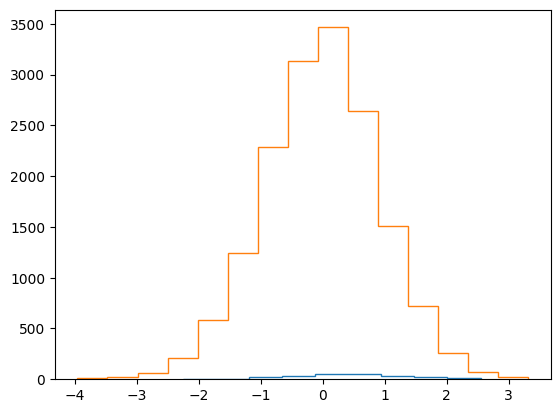

In [10]:
kp = 164.27
vsys = -17.91
sampling = 1.30

frames = np.array(relative_phase)
out_transit_mask = mask_out_transit

# RV formula
rvp = (kp * np.sin(2. * np.pi * phase) - rvcor + vsys)[out_transit_mask>0]
# plt.figure(dpi=100)
# plt.pcolormesh(RV_sample,frames[out_transit_mask>0],cc_total_temp[0][out_transit_mask>0])
# plt.pcolormesh(RV_sample,frames[out_transit_mask>0],cc[0][out_transit_mask>0])
# plt.plot(rvp,frames[out_transit_mask>0],c='white')

kp_2 = 162.50
vsys_2 = -17.91 + 4.8
rvp_2 = (kp_2 * np.sin(2. * np.pi * phase) - rvcor + vsys_2)[out_transit_mask>0]
# plt.plot(rvp_2,frames[out_transit_mask>0],c='red')

# in-trail distribution --> +- 5 pixels from the RV path (assuming 1.30 km/s sampling)
rvp_min_it = rvp_2 - 5
rvp_max_it = rvp_2 + 5
rvp_min_ot = rvp_min_it - 5
rvp_max_ot = rvp_max_it + 5
in_trail,out_trail = [],[]
for ph in range(len(frames[out_transit_mask>0])):
    for idx_rv,rv in enumerate(RV_sample):
        if rv < rvp_max_it[ph] and rv > rvp_min_it[ph]:
            in_trail.append(cc_total_temp[0][out_transit_mask>0][ph][idx_rv])
        elif rv > rvp_max_ot[ph] or rv < rvp_min_ot[ph]:
            out_trail.append(cc_total_temp[0][out_transit_mask>0][ph][idx_rv])

# plt.plot(rvp_min_it,frames[out_transit_mask>0],c='black')
# plt.plot(rvp_max_it,frames[out_transit_mask>0],c='black')
# plt.plot(rvp_min_ot,frames[out_transit_mask>0],c='blue')
# plt.plot(rvp_max_ot,frames[out_transit_mask>0],c='blue')
# plt.xlim(-70,10)
# plt.show()

num_bins_it = int(1 + 3.322*np.log10(len(in_trail))) # following Sturge's rule
num_bins_ot = int(1 + 3.322*np.log10(len(out_trail))) # following Sturge's rule

mean_it = fitting_histogram_welcht(in_trail,plot=False)
mean_ot = fitting_histogram_welcht(out_trail,plot=False)

# plt.figure(dpi=100)
# plt.hist(in_trail, density=True, bins=num_bins_it,histtype='step',label='In-trail',color='blue')
# plt.hist(out_trail, density=True, bins=num_bins_ot,histtype='step',label='Out-trail',color='orange')
# plt.axvline(x=0.3100739836180232,ls='--',color='blue',lw=0.8)
# plt.axvline(x=-0.005249554565047237,ls='--',color='orange',lw=0.8)
# plt.ylabel('Probability')
# plt.xlabel('CCF value')
# plt.legend()

# plt.figure()
# stats.probplot(np.array(out_trail), dist="norm",plot=plt)
# plt.show()
# stats.probplot(np.array(in_trail), dist="norm",plot=plt)
# plt.show()

# Converting the half p-value to significance using inverse survival function
print(stats.ttest_ind(np.array(in_trail), np.array(out_trail), equal_var = False))
norm.isf(stats.ttest_ind(np.array(in_trail), np.array(out_trail), equal_var = False)[1]/2)

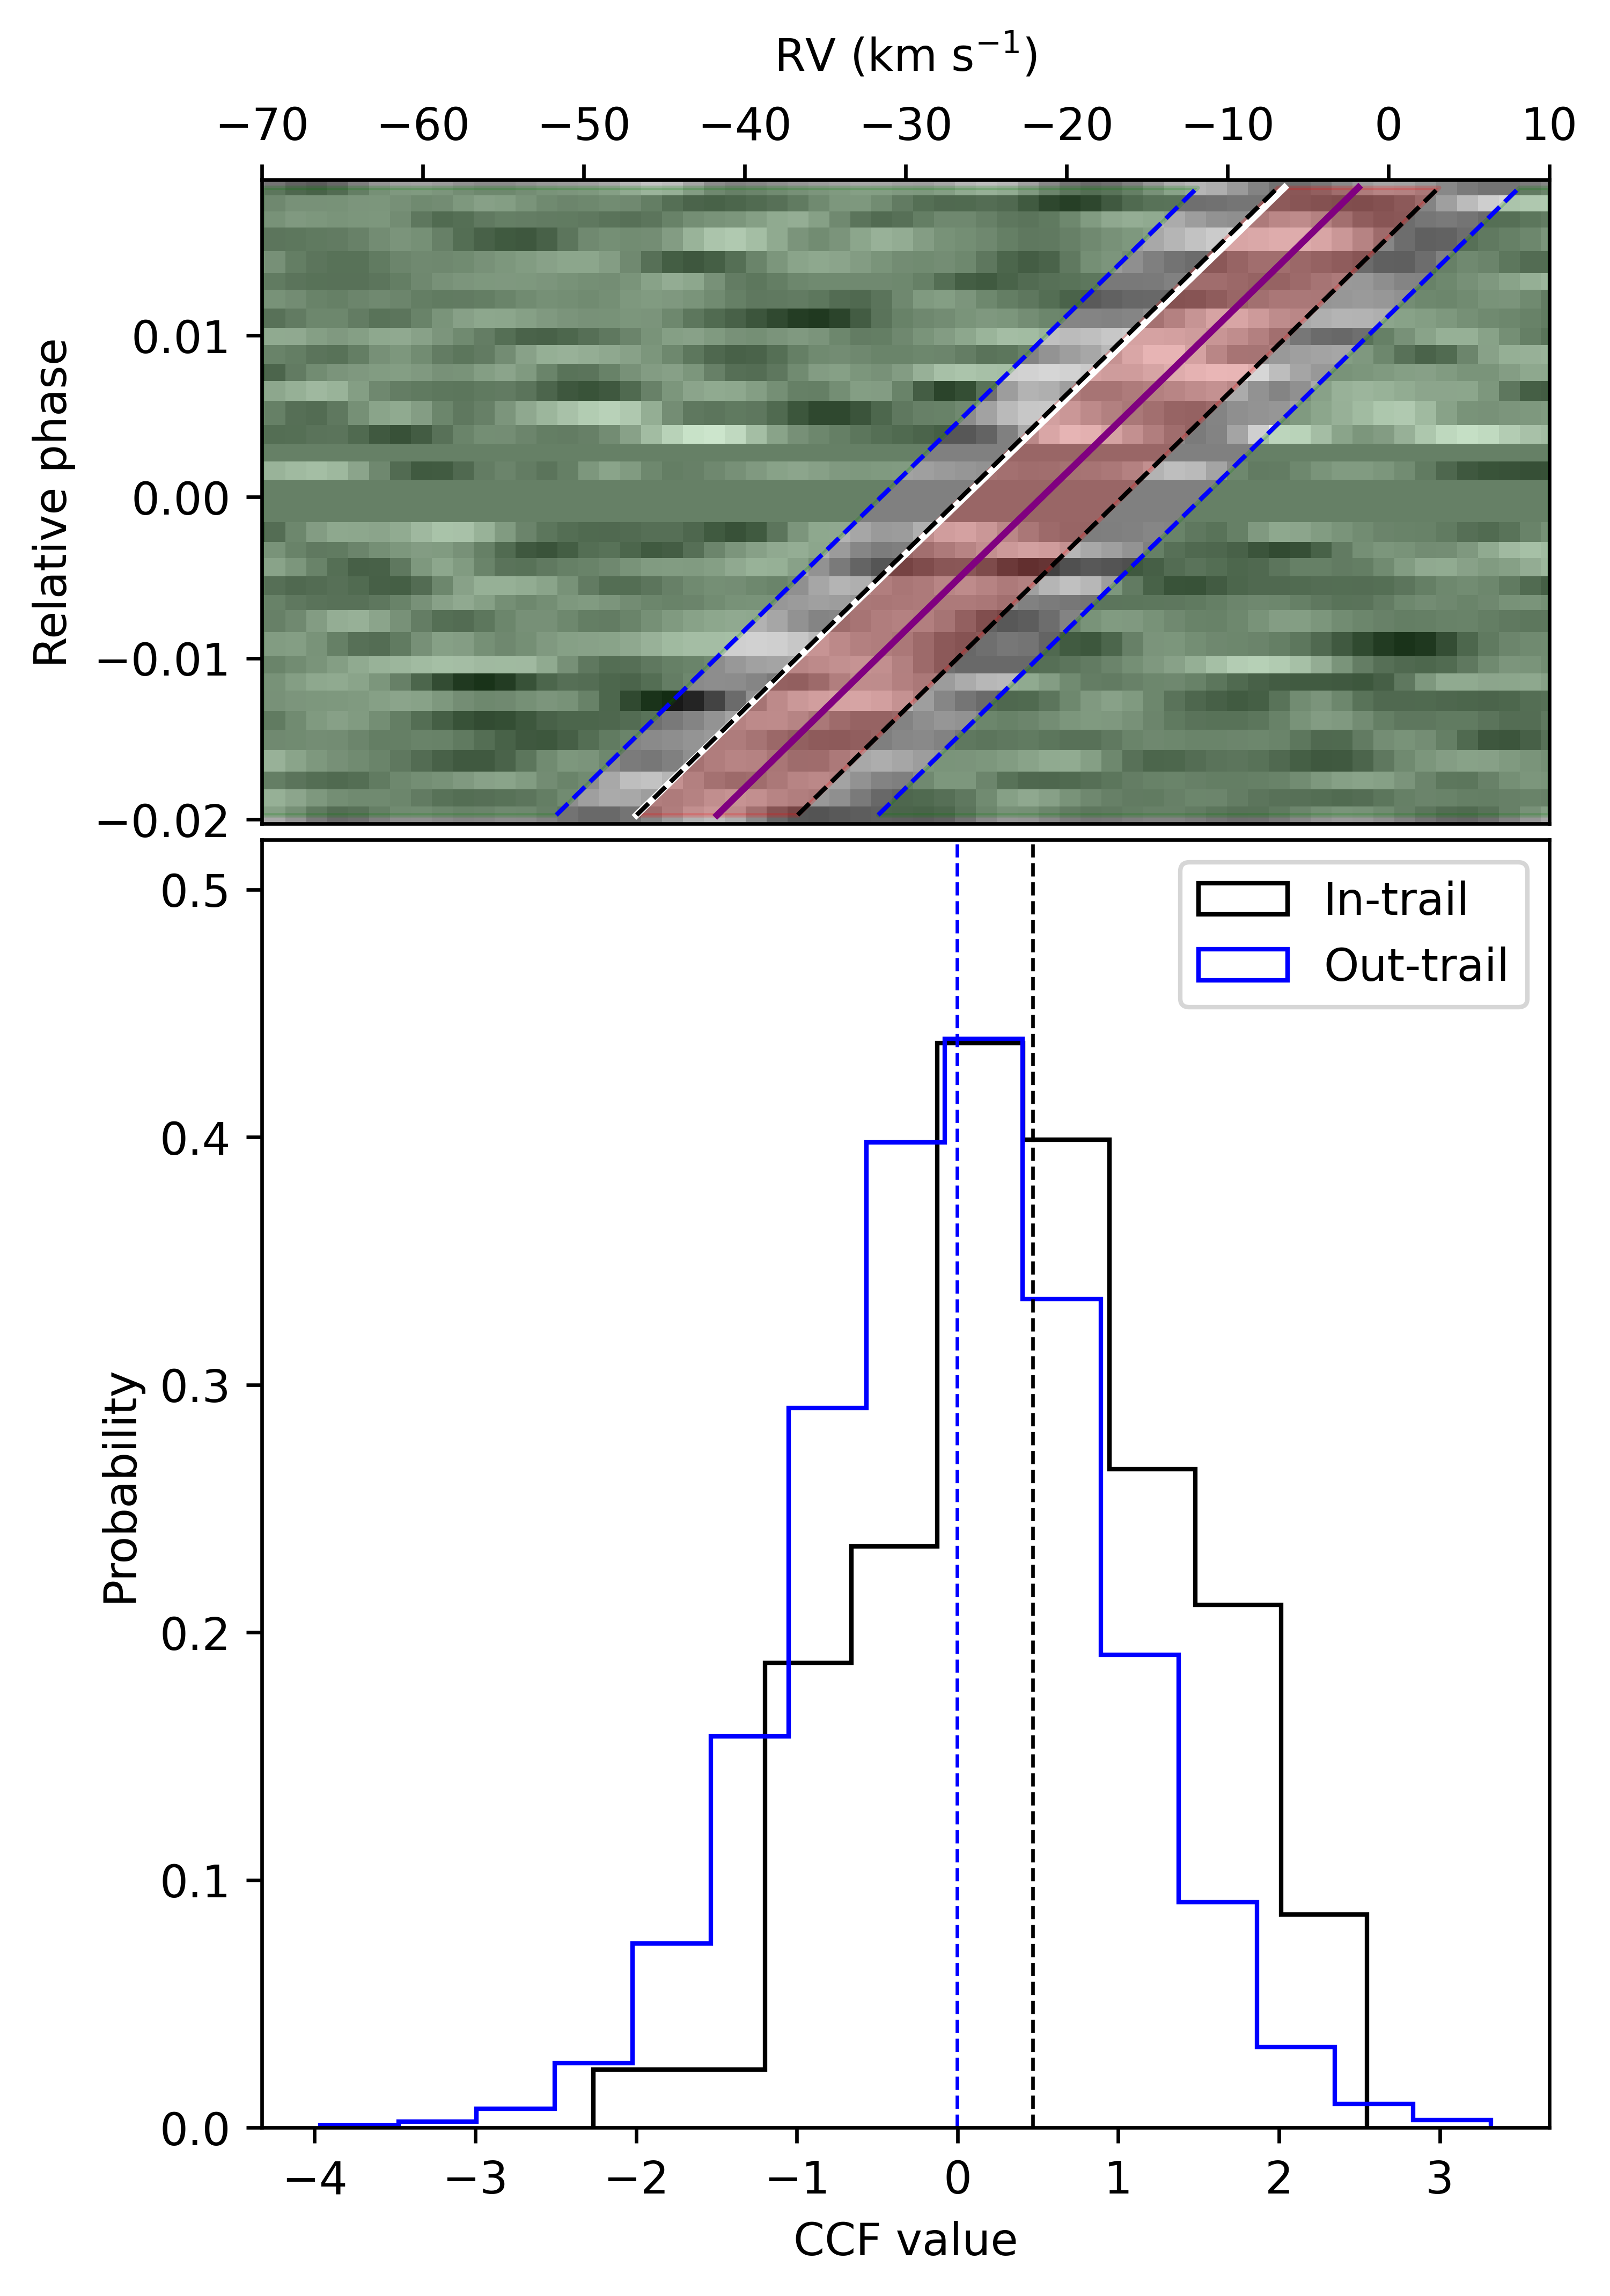

<Figure size 640x480 with 0 Axes>

In [12]:
colorm = 'gray'
cmap = plt.get_cmap(colorm)
cmap.set_bad(color = 'grey', alpha = 1.)

axes_rv = [0, 0, 0.4, 0.2]
axes_hist = [0, 0-0.405, 0.4, 0.4]

fig = plt.figure(figsize=(10, 10),dpi=600)
rv = plt.axes(axes_rv)
hist = plt.axes(axes_hist)

frames = np.array(relative_phase)
out_transit_mask = mask_out_transit
rv.pcolormesh(RV_sample,frames[out_transit_mask>0],cc_total_temp[0][out_transit_mask>0],cmap=cmap)
#rv.pcolormesh(RV_sample,frames[out_transit_mask>0],cc[0][out_transit_mask>0],cmap=cmap)
rv.plot(rvp,frames[out_transit_mask>0],c='white')
rv.plot(rvp_2,frames[out_transit_mask>0],c='purple')
rv.plot(rvp_min_it,frames[out_transit_mask>0],c='black',ls='--',lw=1)
rv.plot(rvp_max_it,frames[out_transit_mask>0],c='black',ls='--',lw=1)
rv.fill_betweenx(frames[out_transit_mask>0], rvp_min_it, rvp_max_it, alpha=0.2, color='red')

rv.plot(rvp_min_ot,frames[out_transit_mask>0],c='blue',ls='--',lw=1)
rv.plot(rvp_max_ot,frames[out_transit_mask>0],c='blue',ls='--',lw=1)
rv.fill_betweenx(y=frames[out_transit_mask>0], x1=-70, x2=rvp_min_ot, color='green', alpha=0.2)
rv.fill_betweenx(y=frames[out_transit_mask>0], x1=rvp_max_ot, x2=10, color='green', alpha=0.2)

rv.set_xlim(-70,10)
rv.set_xlabel('RV (km s$^{-1}$)')
rv.set_ylabel('Relative phase')
rv.xaxis.set_ticks_position("top")
rv.xaxis.set_label_coords(0.5, 1.23)

hist.hist(in_trail, density=True, bins=num_bins_it,histtype='step',label='In-trail',color='black')
hist.hist(out_trail, density=True, bins=num_bins_ot,histtype='step',label='Out-trail',color='blue')
hist.axvline(x=mean_it,ls='--',color='black',lw=0.8)
hist.axvline(x=mean_ot,ls='--',color='blue',lw=0.8)
hist.set_ylabel('Probability')
hist.set_xlabel('CCF value')
hist.set_ylim(0,0.52)
hist.legend()

plt.subplots_adjust(top=0.95, bottom=0.25)
plt.savefig("figures/it_and_ot.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show(block=False)
plt.clf()